### Import and Load model

In [2]:
import time
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from scipy.stats import entropy
from tqdm import tqdm

import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn

from utils.plots import plot_pr,plot_roc, plot_dist, plot_violin,plot_ecdf,save_fig
from utils.metircs import accuracy,mutual_info,nll, ece, predictive_entropy,expected_kl,predictive_variance
from utils.visual import ProgressMeter, AverageMeter, Summary
from data_utils.get_datasets import get_dataset
from model_utils.get_models import get_model
from uncertainty.mc_dropout import mc_dropout_predict
from uncertainty.test_time_aug import test_time_aug_predict
from uncertainty.deep_ensemble import deep_ensembel_predict,EnsembleModel
from uncertainty.baseline_softmax import baseline_softmax_predict
from uncertainty.bnn_svi import bnn_svi_predict
from adversarial.adversarial_attack import fgsm_attack, pgd_attack

In [3]:
device = torch.device('cuda:0')
model = get_model("vgg16", 10, use_torchvision=False)
model = model.to(device)
model.eval()
checkpoint = torch.load("../saved_models/deterministic/vgg16/2023_11_24_15_25_21/vgg16_best_model_93.62.pth",map_location=device)
model.load_state_dict(checkpoint['state_dict'])
models_path = ["../saved_models/deterministic/vgg16/2023_11_24_14_58_46/vgg16_best_model_93.60.pth",
               "../saved_models/deterministic/vgg16/2023_11_24_15_25_21/vgg16_best_model_93.62.pth",
               "../saved_models/deterministic/vgg16/2023_11_24_19_17_18/vgg16_best_model_93.81.pth",
               "../saved_models/deterministic/vgg16/2023_11_24_19_22_52/vgg16_best_model_93.95.pth",
               "../saved_models/deterministic/vgg16/2023_11_27_15_31_22/vgg16_best_model_93.76.pth"
              ]
vgg_ensemble = EnsembleModel("vgg16", models_path, device)

use private models...
use private models...
use private models...
use private models...
use private models...
use private models...


In [4]:
# summary(model,(3,32,32))
# print(model)

In [5]:
#random Gaussian noise fed into an image classifier gives a “prediction confidence” or predicted class probability of 91%
noise = torch.randn(64,3,32,32).to(device)
prob = vgg_ensemble(noise)
print(torch.max(prob,axis=1))

torch.return_types.max(
values=tensor([0.5118, 0.4116, 0.3774, 0.4916, 0.3464, 0.4982, 0.4178, 0.4624, 0.4071,
        0.3650, 0.3675, 0.4839, 0.3517, 0.3426, 0.3708, 0.4592, 0.3752, 0.4204,
        0.4041, 0.4058, 0.3528, 0.4354, 0.3989, 0.3918, 0.4579, 0.4209, 0.3476,
        0.4976, 0.3595, 0.3475, 0.3409, 0.3680, 0.5441, 0.5154, 0.5258, 0.4388,
        0.3623, 0.4029, 0.3999, 0.3684, 0.4445, 0.4512, 0.3574, 0.4277, 0.3884,
        0.3384, 0.3998, 0.4407, 0.4123, 0.4070, 0.4362, 0.4828, 0.3519, 0.3605,
        0.5112, 0.5750, 0.4143, 0.5584, 0.4238, 0.3826, 0.3847, 0.4063, 0.3802,
        0.3505], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4, 4, 4, 6, 4, 6, 6, 6, 4, 4, 4, 6, 4, 4, 4, 6, 4, 6, 4, 6, 4, 6, 6, 6,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 6, 4, 4, 4, 4, 4, 6,
        6, 4, 6, 4, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 4, 4], device='cuda:0'))


### Deep Ensemble 

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
datanames = ["cifar10","mnist", "fashionmnist","svhn"]
probs_list = []
targets_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
    ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    probs, targets = deep_ensembel_predict(val_loader, vgg_ensemble,  device)
    probs_list.append(probs.cpu().detach().numpy())
    targets_list.append(targets.cpu().detach().numpy())

 * Time 0.009 Acc@1 95.330
 * Time 0.009 Acc@1 7.540
 * Time 0.009 Acc@1 9.320
 * Time 0.009 Acc@1 10.837


#### misclassified

In [8]:
print(probs_list[0].shape)

(10000, 5, 10)


In [9]:
cifar10_mi =  mutual_info(probs_list[0])*-1
cifar10_probs = np.mean(probs_list[0],axis=1)
cifar10_target = targets_list[0]

In [10]:
cifar10_pred = np.argmax(cifar10_probs,axis=1)
labels = (cifar10_pred == cifar10_target).astype(int)#正确分类标为1，误分类标为0
random_pred = np.random.rand(labels.shape[0])

In [11]:
succ_mi_mean = cifar10_mi[labels==1].mean()
err_mi_mean = cifar10_mi[labels==0].mean()
print(f"正确分类样本数{labels.sum()},平均MI:{succ_mi_mean:.3f}\n错误分类样本数{(1-labels).sum()},平均MI:{err_mi_mean:.3f}")

正确分类样本数9533,平均MI:-0.073
错误分类样本数467,平均MI:-0.292


In [12]:
cifar10_ent = predictive_entropy(probs_list[0])*-1
succ_ent_mean = cifar10_ent[labels==1].mean()
err_ent_mean = cifar10_ent[labels==0].mean()
print(f"正确分类样本数{labels.sum()},平均ENT:{succ_ent_mean:.3f}\n错误分类样本数{(1-labels).sum()},平均ENT:{err_ent_mean:.3f}")

正确分类样本数9533,平均ENT:-0.273
错误分类样本数467,平均ENT:-0.707


In [13]:
cifar10_ekl = expected_kl(probs_list[0])*-1
succ_ekl_mean = cifar10_ekl[labels==1].mean()
err_ekl_mean = cifar10_ekl[labels==0].mean()
print(f"正确分类样本数{labels.sum()},平均EKL:{succ_ekl_mean:.3f}\n错误分类样本数{(1-labels).sum()},平均EKL:{err_ekl_mean:.3f}")

正确分类样本数9533,平均EKL:-0.201
错误分类样本数467,平均EKL:-0.552


In [14]:
cifar10_var = predictive_variance(probs_list[0])*-1
succ_var_mean = cifar10_var[labels==1].mean()
err_var_mean = cifar10_var[labels==0].mean()
print(f"正确分类样本数{labels.sum()},平均VAR:{succ_var_mean:.3f}\n错误分类样本数{(1-labels).sum()},平均VAR:{err_var_mean:.3f}")

正确分类样本数9533,平均VAR:-0.467
错误分类样本数467,平均VAR:-1.696


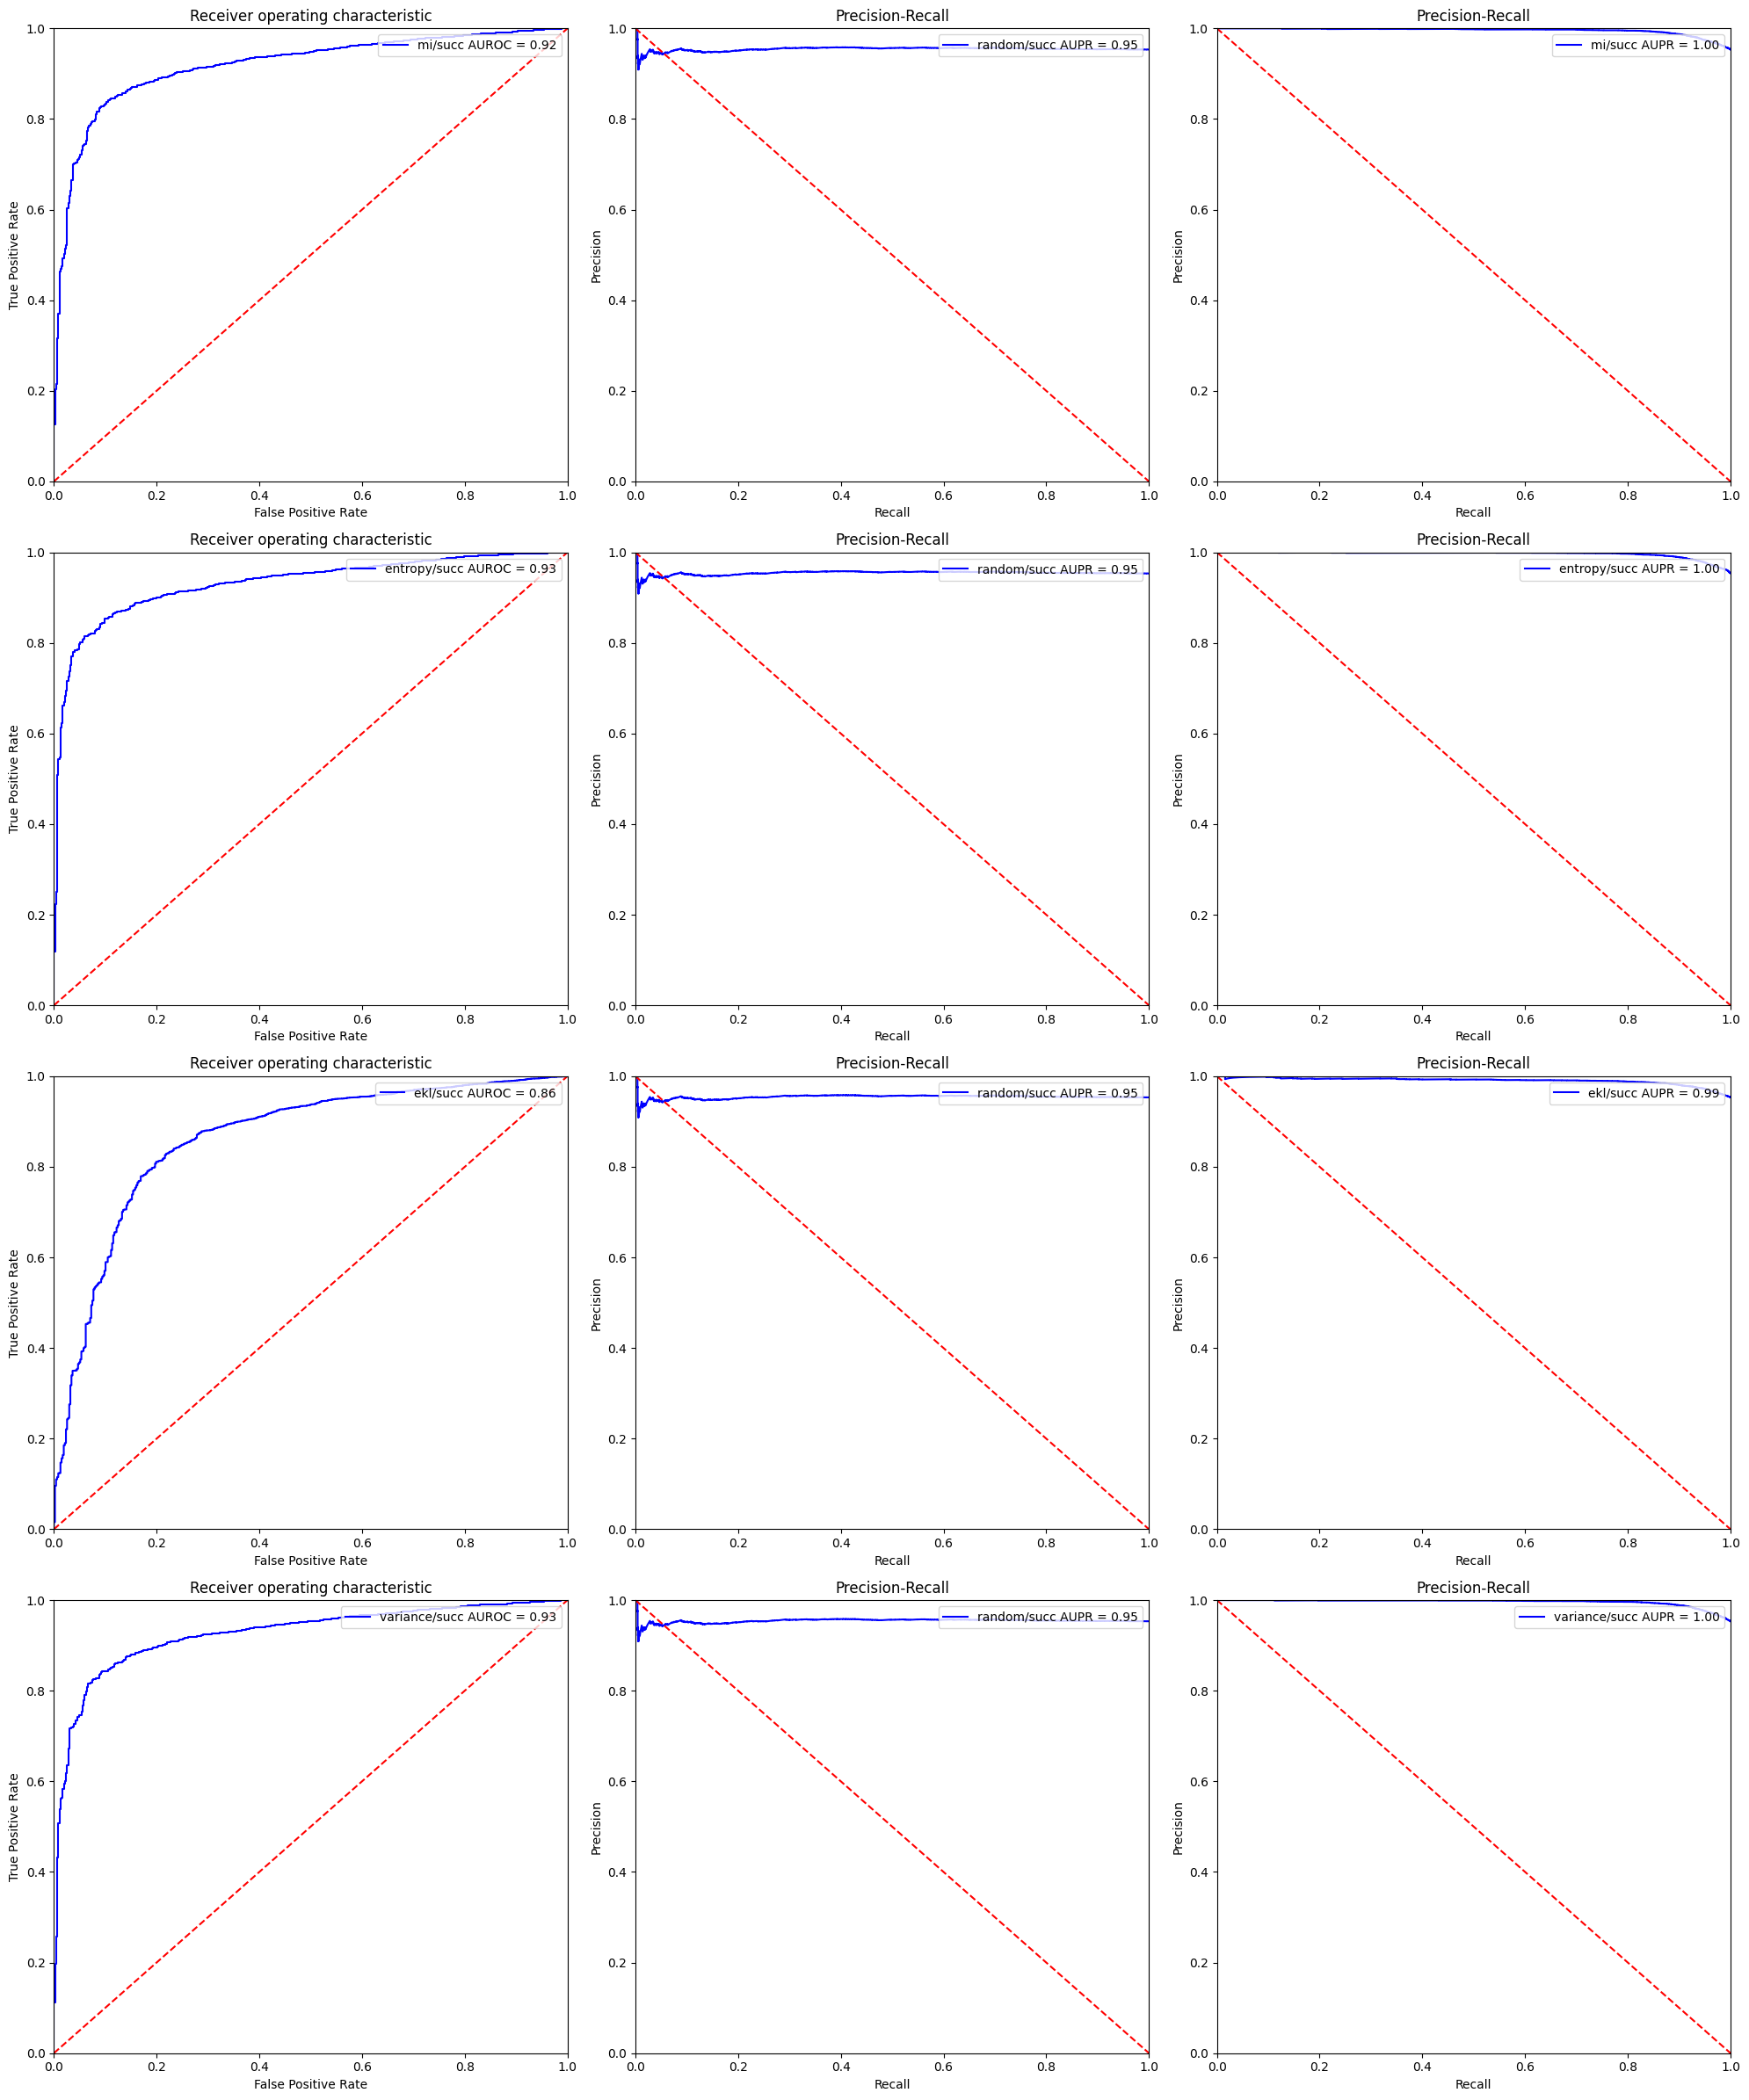

In [15]:
fig, axes = plt.subplots(4,3, figsize=(20, 24))
plot_roc(axes[0][0], labels,cifar10_mi,"mi/succ")
plot_pr(axes[0][1],labels,random_pred,"random/succ")
plot_pr(axes[0][2],labels,cifar10_mi,"mi/succ")
plot_roc(axes[1][0], labels,cifar10_ent,"entropy/succ")
plot_pr(axes[1][1],labels,random_pred,"random/succ")
plot_pr(axes[1][2],labels,cifar10_ent,"entropy/succ")
plot_roc(axes[2][0], labels,cifar10_ekl,"ekl/succ")
plot_pr(axes[2][1],labels,random_pred,"random/succ")
plot_pr(axes[2][2],labels,cifar10_ekl,"ekl/succ")
plot_roc(axes[3][0], labels,cifar10_var,"variance/succ")
plot_pr(axes[3][1],labels,random_pred,"random/succ")
plot_pr(axes[3][2],labels,cifar10_var,"variance/succ")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","misclassified_pr_roc.jpg")

In [16]:
labels2 = (cifar10_pred != cifar10_target).astype(int)#误分类标为1，正确分类标为0
cifar10_mi2 = -cifar10_mi
random_pred2 = -random_pred
cifar10_ent2 = -cifar10_ent 
cifar10_ekl2 = -cifar10_ekl
cifar10_var2 = -cifar10_var

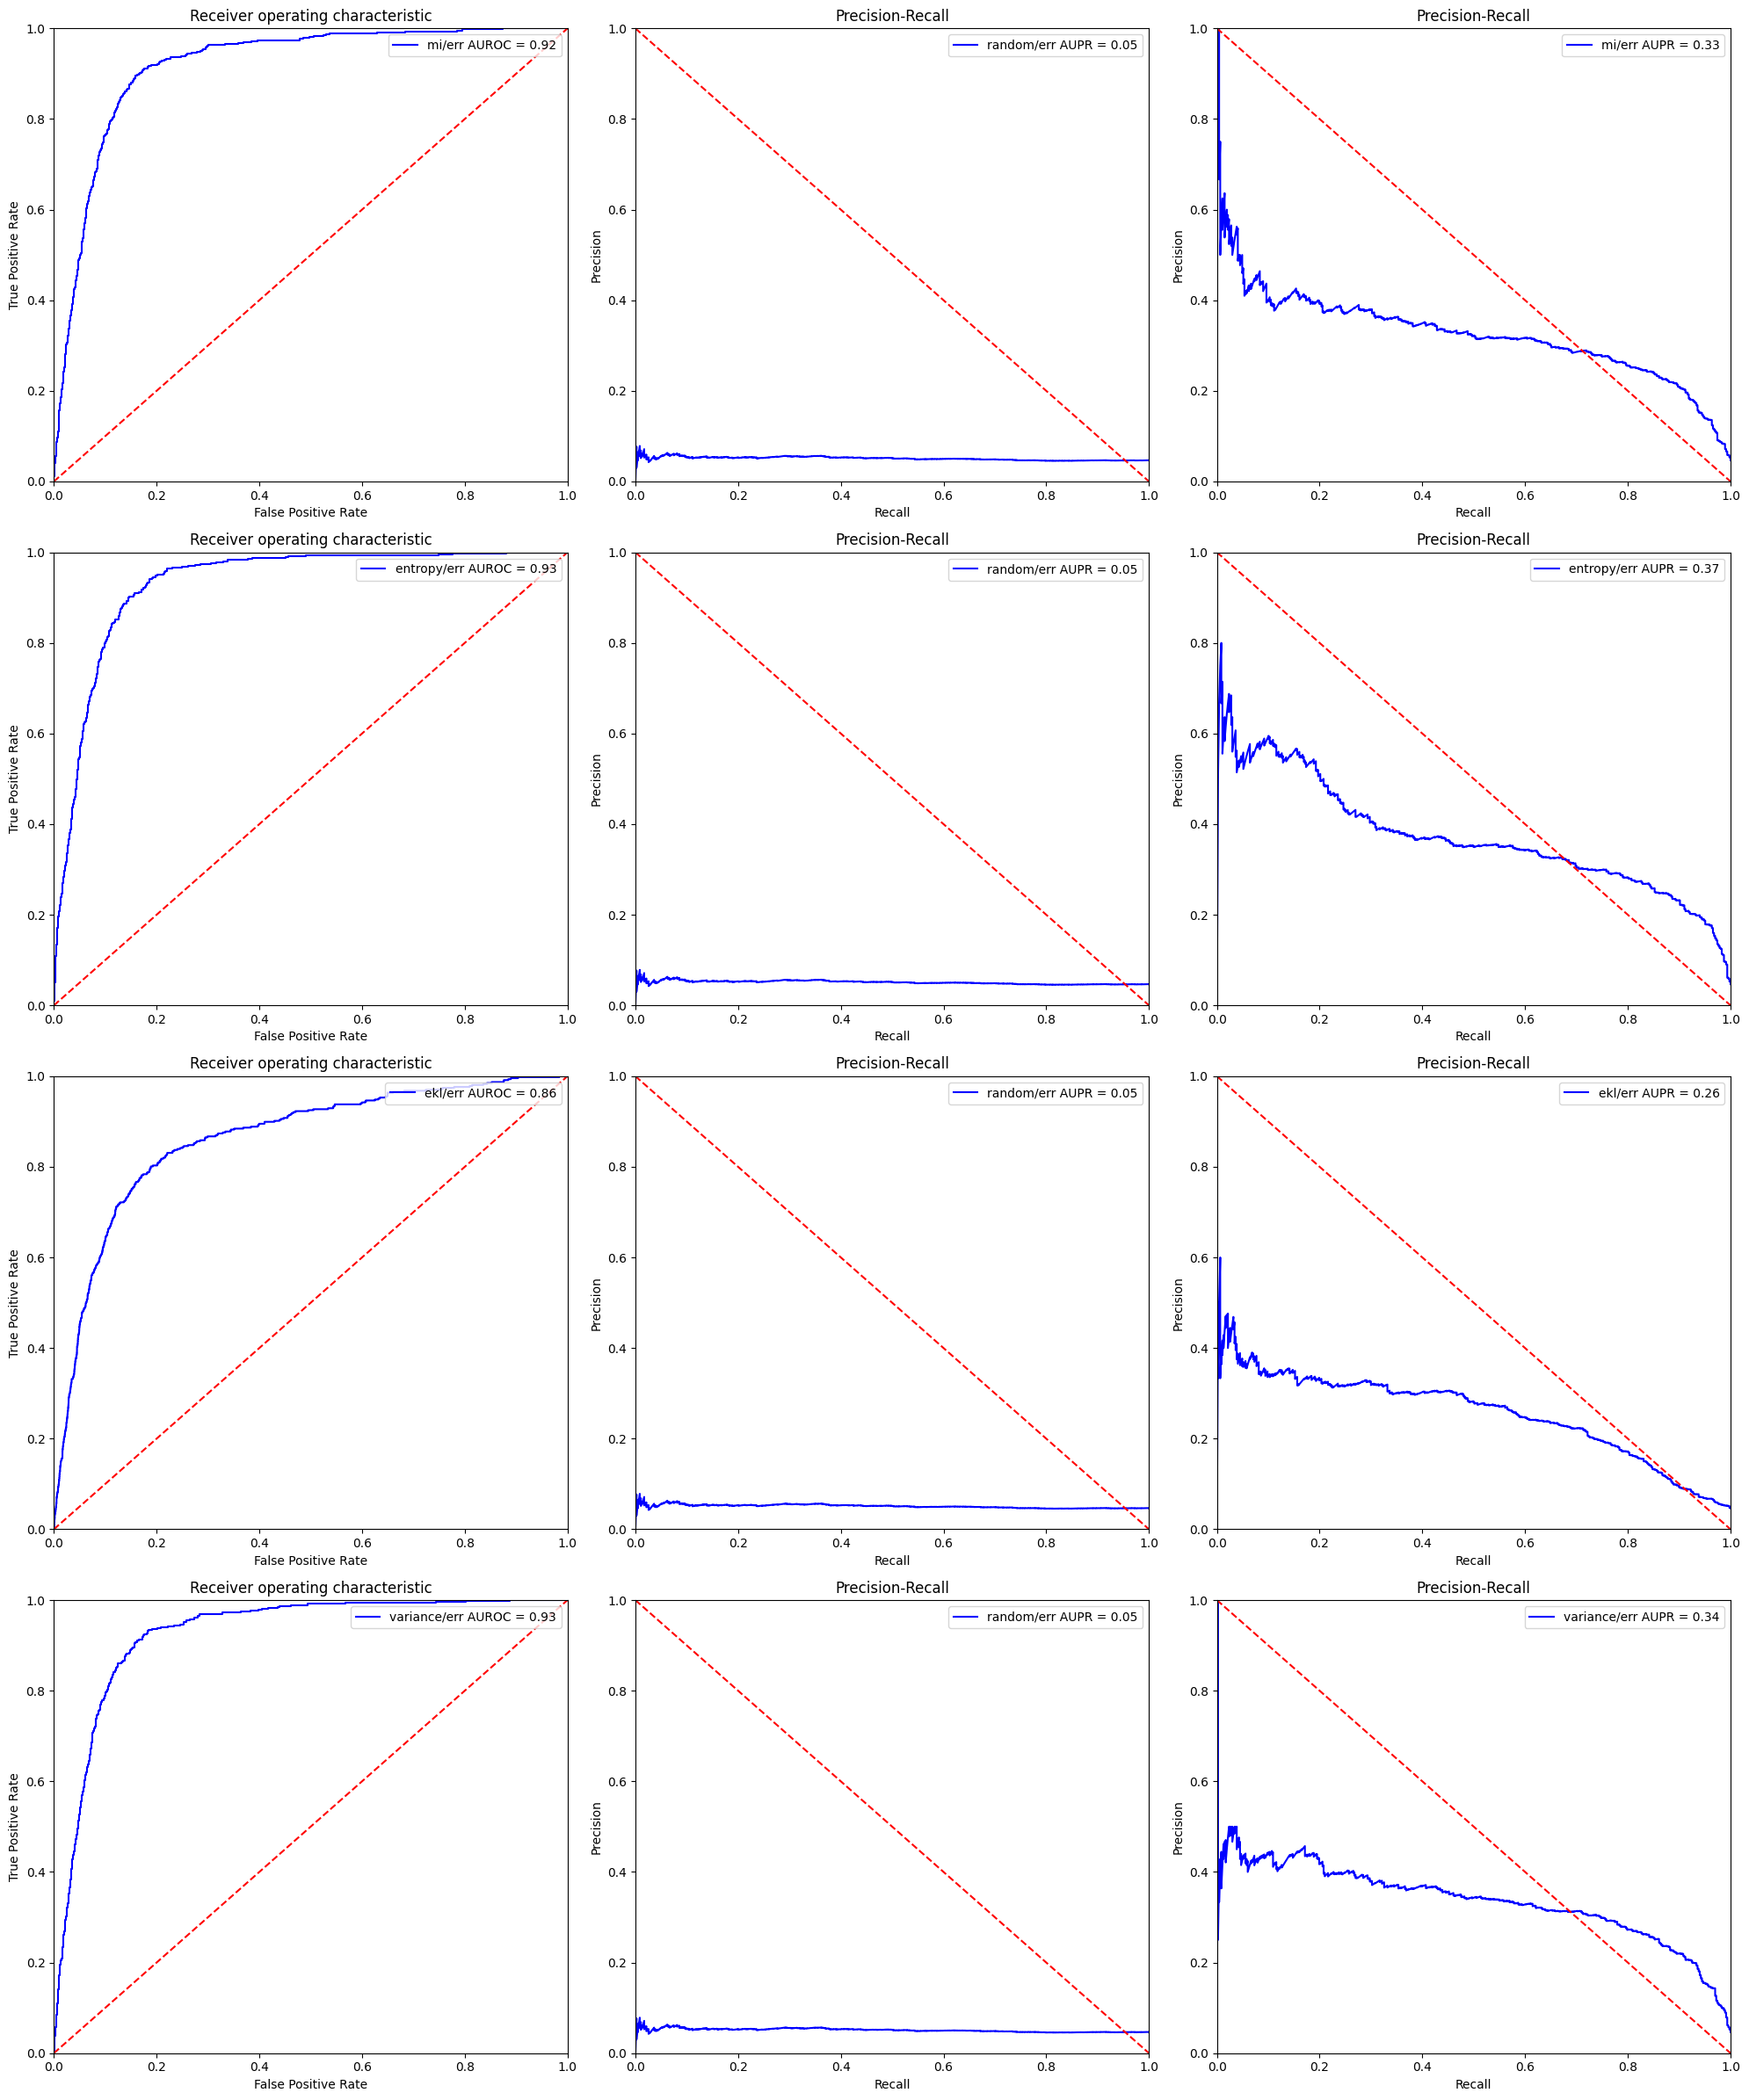

In [17]:
fig, axes = plt.subplots(4,3, figsize=(20, 24))
plot_roc(axes[0][0], labels2,cifar10_mi2,"mi/err")
plot_pr(axes[0][1],labels2,random_pred2,"random/err")
plot_pr(axes[0][2],labels2,cifar10_mi2,"mi/err")
plot_roc(axes[1][0], labels2,cifar10_ent2,"entropy/err")
plot_pr(axes[1][1],labels2,random_pred2,"random/err")
plot_pr(axes[1][2],labels2,cifar10_ent2,"entropy/err")
plot_roc(axes[2][0], labels2,cifar10_ekl2,"ekl/err")
plot_pr(axes[2][1],labels2,random_pred2,"random/err")
plot_pr(axes[2][2],labels2,cifar10_ekl2,"ekl/err")
plot_roc(axes[3][0], labels2,cifar10_var2,"variance/err")
plot_pr(axes[3][1],labels2,random_pred2,"random/err")
plot_pr(axes[3][2],labels2,cifar10_var2,"variance/err")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","misclassified_pr_roc2.jpg")

#### OOD

In [18]:
mi_list = []
for i, probs in enumerate(probs_list):
    mi = mutual_info(probs)
    mi_list.append(mi)

In [19]:
ent_list = []
for i, probs in enumerate(probs_list):
    ent = predictive_entropy(probs)
    ent_list.append(ent)

In [20]:
ekl_list = []
for i, probs in enumerate(probs_list):
    ekl = expected_kl(probs)
    ekl_list.append(ekl)

In [21]:
var_list = []
for i, probs in enumerate(probs_list):
    var = predictive_variance(probs)
    var_list.append(var)

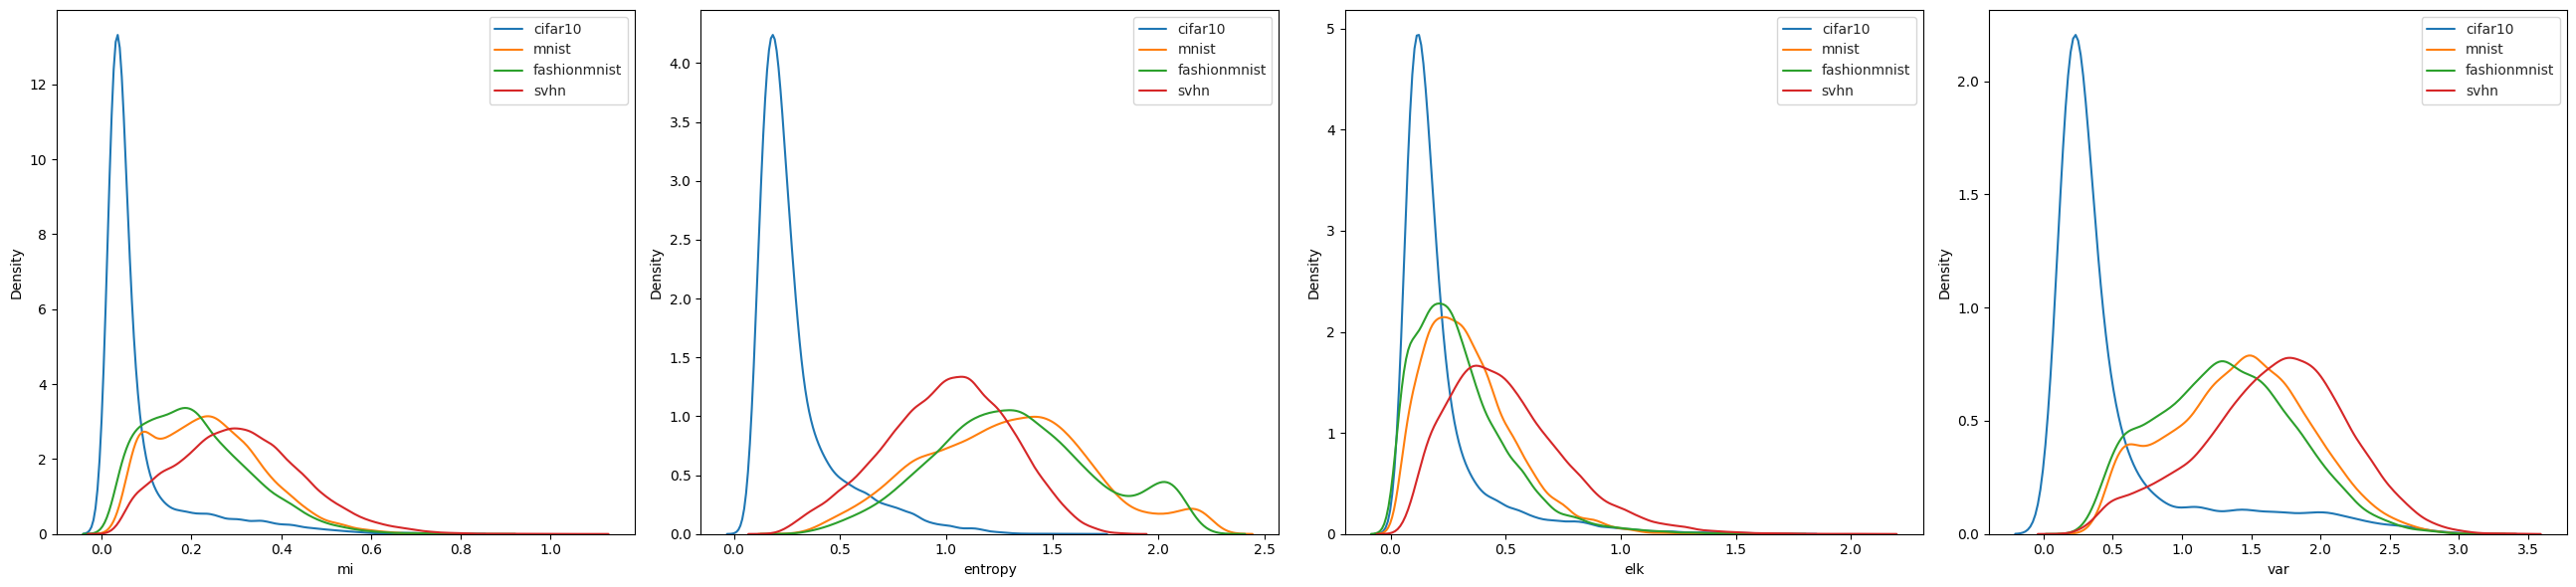

In [22]:
#绘制mi,熵的分布
fig, axes = plt.subplots(1,4, figsize=(26, 6))
plot_dist(axes[0],mi_list,datanames,"mi")
plot_dist(axes[1], ent_list,datanames,"entropy")
plot_dist(axes[2],ekl_list,datanames,"ekl")
plot_dist(axes[3], var_list,datanames,"var")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","ood_dist.jpg")

In [23]:
#绘制小提琴图
fig, axes = plt.subplots(4,4, figsize=(25, 24))
plot_violin(axes[0],mi_list,datanames,"mi")
plot_violin(axes[1], ent_list,datanames,"entropy")
plot_violin(axes[2],ekl_list,datanames,"ekl")
plot_violin(axes[3], var_list,datanames,"var")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","ood_violin.jpg")

In [24]:
#IND样本视为正样本， mnist样本视为负样本
ood_idx=1
print(f"cifar10 test nums:{len(mi_list[0])},mnist test nums:{len(mi_list[1])}")
labels = [1]*len(mi_list[0])+[0]*len(mi_list[ood_idx])
mi = np.concatenate([mi_list[0],mi_list[ood_idx]])*-1
ent = np.concatenate([ent_list[0],ent_list[ood_idx]])*-1
ekl = np.concatenate([ekl_list[0],ekl_list[ood_idx]])*-1
var = np.concatenate([var_list[0],var_list[ood_idx]])*-1
random_pred = np.random.rand(len(labels))*-1

cifar10 test nums:10000,mnist test nums:10000


In [25]:
fig, axes = plt.subplots(4,3, figsize=(20, 24))
plot_roc(axes[0][0], labels,mi,"mi/ind")
plot_pr(axes[0][1],labels,random_pred,"random/ind")
plot_pr(axes[0][2],labels,mi,"mi/ind")
plot_roc(axes[1][0], labels,ent,"entropy/ind")
plot_pr(axes[1][1],labels,random_pred,"random/ind")
plot_pr(axes[1][2],labels,ent,"entropy/ind")
plot_roc(axes[2][0], labels,ekl,"ekl/ind")
plot_pr(axes[2][1],labels,random_pred,"random/ind")
plot_pr(axes[2][2],labels,ekl,"ekl/ind")
plot_roc(axes[3][0], labels,var,"var/ind")
plot_pr(axes[3][1],labels,random_pred,"random/ind")
plot_pr(axes[3][2],labels,var,"var/ind")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","ood_pr_roc.jpg")

In [26]:
#IND样本视为负样本， mnist样本视为正样本
labels2 = [0]*len(mi_list[0])+[1]*len(mi_list[1])
mi2 =  -mi
ent2 = -ent
ekl2 = -ekl
var2 = -var
random_pred2 = -random_pred

In [27]:
fig, axes = plt.subplots(4,3, figsize=(20, 24))
plot_roc(axes[0][0], labels2,mi2,"mi/ood")
plot_pr(axes[0][1],labels2,random_pred2,"random/ood")
plot_pr(axes[0][2],labels2,mi2,"mi/ood")
plot_roc(axes[1][0], labels2,ent2,"entropy/ood")
plot_pr(axes[1][1],labels2,random_pred2,"random/ood")
plot_pr(axes[1][2],labels2,ent2,"entropy/ood")
plot_roc(axes[2][0], labels2,ekl2,"ekl/ood")
plot_pr(axes[2][1],labels2,random_pred2,"random/ood")
plot_pr(axes[2][2],labels2,ekl2,"ekl/ood")
plot_roc(axes[3][0], labels2,var2,"var/ood")
plot_pr(axes[3][1],labels2,random_pred2,"random/ood")
plot_pr(axes[3][2],labels2,var2,"var/ood")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","ood_pr_roc2.jpg")

#### advasarial attack

In [28]:
_, val_dataset = get_dataset("cifar10","../data",None,val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True)

In [29]:
adv_probs_list = []
origin_probs_list = []
method = "fgsm"
epsilon = 0.05
correct = 0
for images, targets in tqdm(val_loader):
    images, targets = images.to(device), targets.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    origin_prob = vgg_ensemble.mc_forward(images) #攻击model
    origin_prob_mean = torch.mean(origin_prob,axis=0)
    _, origin_pred = torch.max(origin_prob_mean,axis=1)
    if origin_pred.item() != targets.item():
            continue
        
    if method == "fgsm":
        perturbed_images = fgsm_attack(vgg_ensemble, images, targets, epsilon,device)
    elif method == "pgd":
        perturbed_images = pgd_attack(vgg_ensemble, images, targets, epsilon,device)

    adv_prob = vgg_ensemble.mc_forward(perturbed_images) #这里使用vgg_ensemble去预测
    adv_prob_mean = torch.mean(adv_prob,axis=0)
    _, adv_pred = adv_prob_mean.max(1, keepdim=True)
    adv_probs_list.append(adv_prob.cpu().detach().numpy())
    origin_probs_list.append(origin_prob.cpu().detach().numpy())


    if adv_pred.item() == targets.item():
        correct += 1

    
adv_acc = correct/float(len(val_loader))
print(
    f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(val_loader)} = {adv_acc}")

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:19<00:00, 10.21it/s]

Epsilon: 0.05	Test Accuracy = 4139 / 10000 = 0.4139


In [30]:
adv_probs = np.concatenate(adv_probs_list,axis=1).transpose(1,0,2)
origin_probs = np.concatenate(origin_probs_list,axis=1).transpose(1,0,2)
print(adv_probs.shape,origin_probs.shape)
print(f"原始样本平均预测概率{np.max(origin_probs,axis=2).mean()},对抗样本平均预测概率{np.max(adv_probs,axis=2).mean()}")

(9533, 5, 10) (9533, 5, 10)
原始样本平均预测概率0.9304759502410889,对抗样本平均预测概率0.7635324597358704


In [31]:
ekl_list = []
for i, probs in enumerate([origin_probs,adv_probs]):
    ekl = expected_kl(probs)
    ekl_list.append(ekl)

In [32]:
mi_list = []
for i, probs in enumerate([origin_probs,adv_probs]):
    mi = mutual_info(probs)
    mi_list.append(mi)

In [33]:
var_list = []
for i, probs in enumerate([origin_probs,adv_probs]):
    var = predictive_variance(probs)
    var_list.append(var)

In [34]:
ent_list = []
for i, probs in enumerate([origin_probs,adv_probs]):
    ent = predictive_entropy(probs)
    ent_list.append(ent)

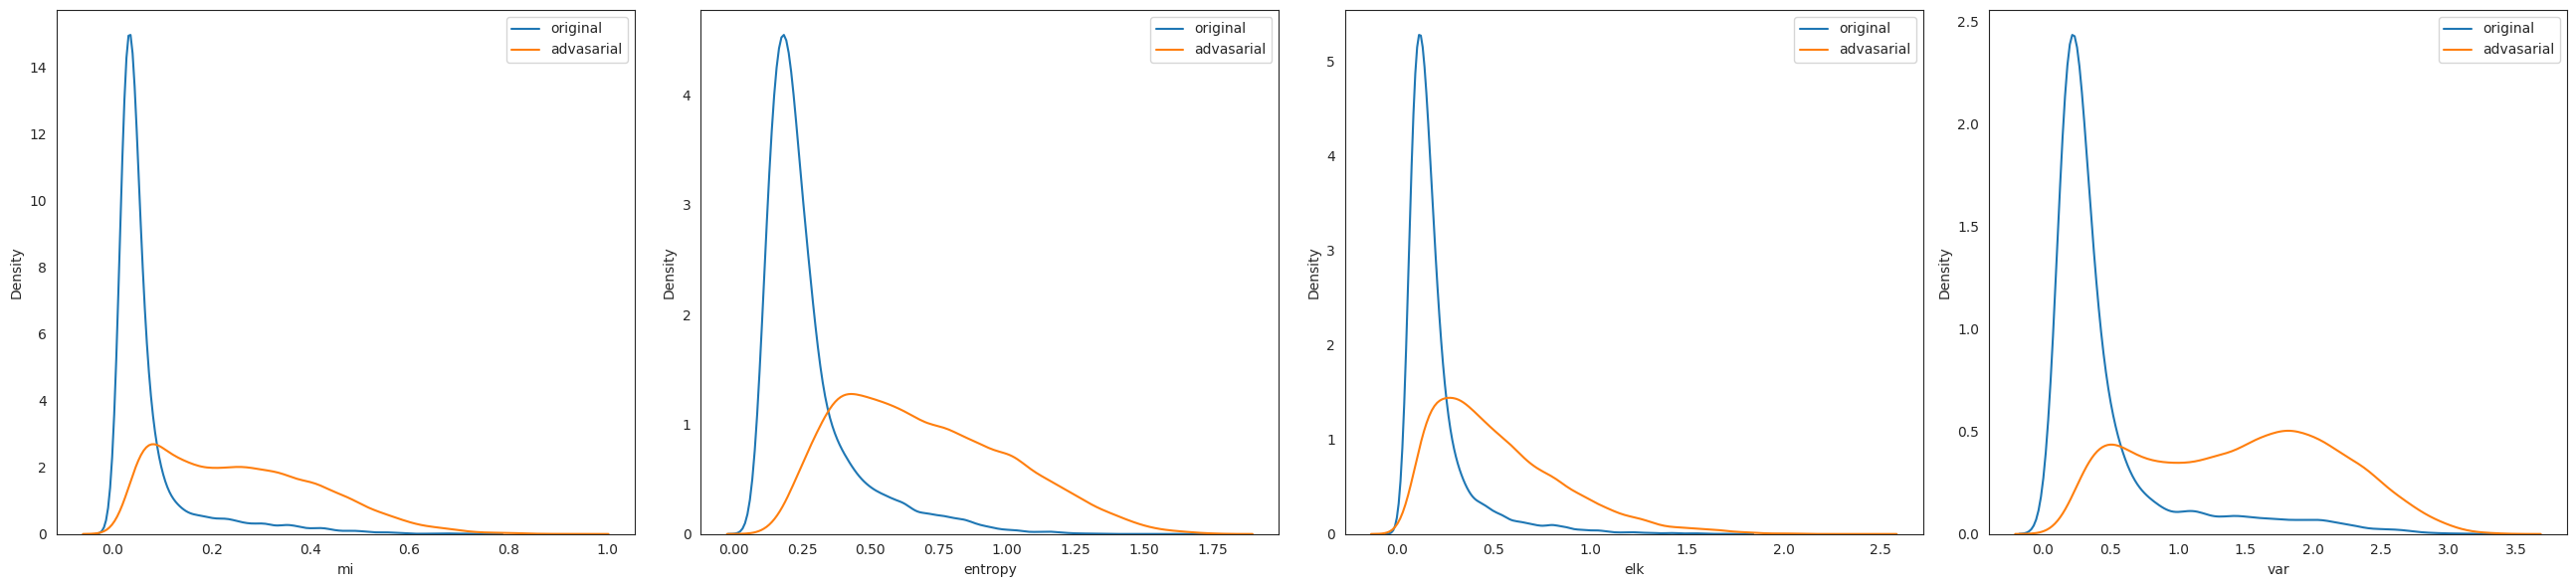

In [35]:
fig, axes = plt.subplots(1,4, figsize=(26, 6))
plot_dist(axes[0],mi_list,["original","advasarial"],"mi")
plot_dist(axes[1], ent_list,["original","advasarial"],"entropy")
plot_dist(axes[2],ekl_list,["original","advasarial"],"ekl")
plot_dist(axes[3], var_list,["original","advasarial"],"var")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","adv_dist.jpg")

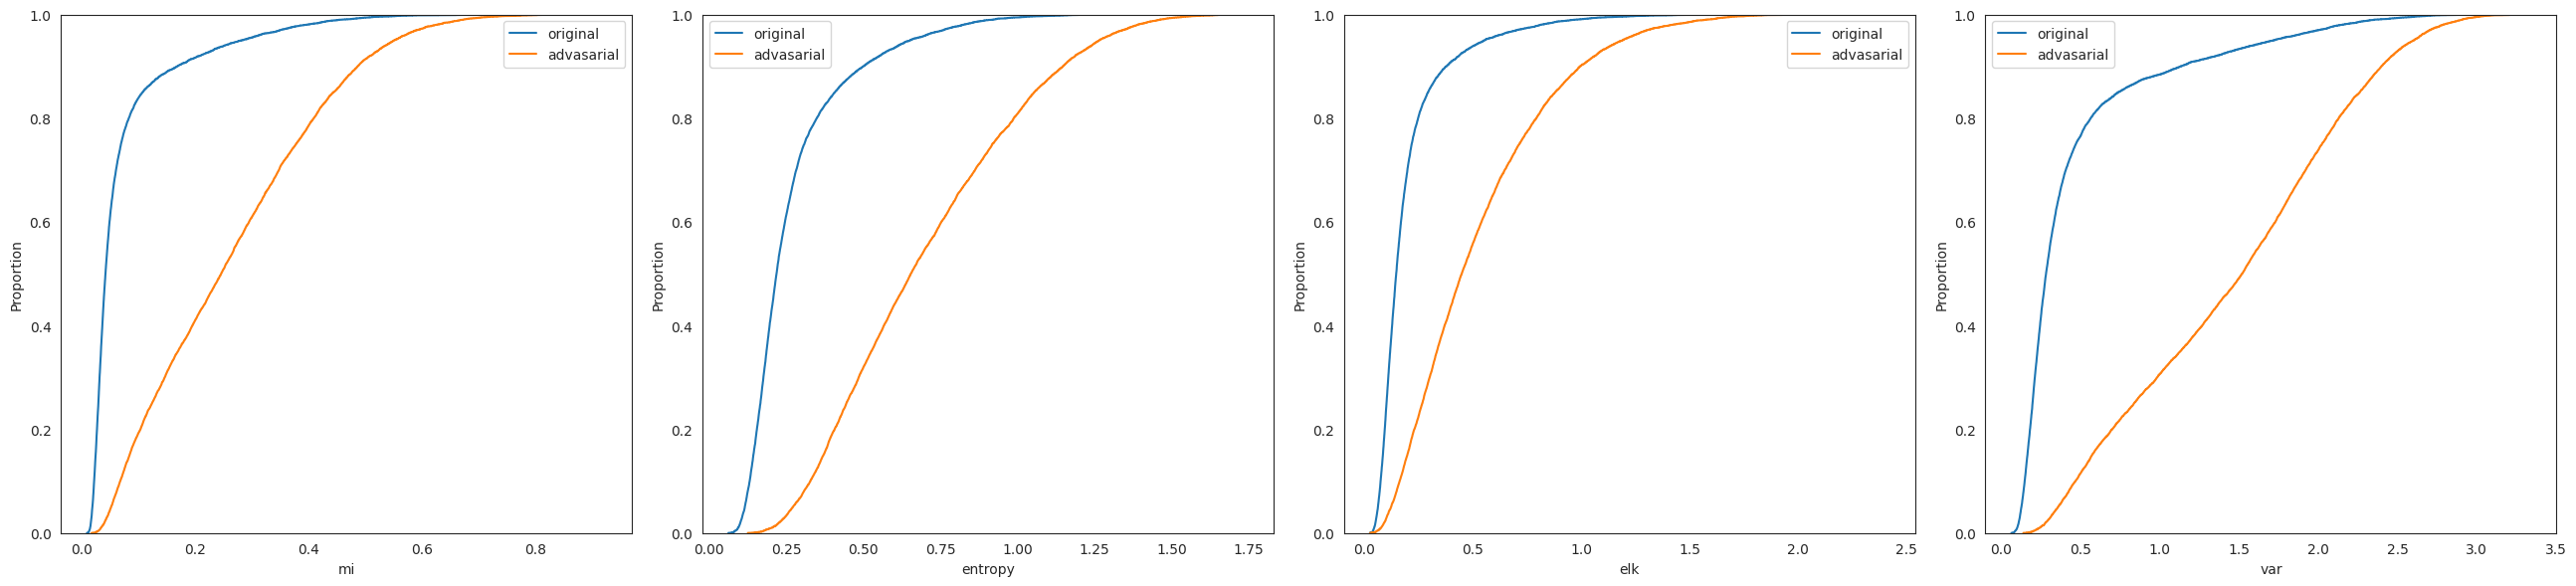

In [36]:
fig, axes = plt.subplots(1,4, figsize=(26, 6))
plot_ecdf(axes[0],mi_list,["original","advasarial"],"mi")
plot_ecdf(axes[1], ent_list,["original","advasarial"],"entropy")
plot_ecdf(axes[2],ekl_list,["original","advasarial"],"ekl")
plot_ecdf(axes[3], var_list,["original","advasarial"],"var")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","adv_ecdf.jpg")

In [37]:
#原始样本视为正样本，攻击样本视为负样本
labels = [1]*len(mi_list[0])+[0]*len(mi_list[1])
mi = np.concatenate([mi_list[0],mi_list[1]])*-1
ent = np.concatenate([ent_list[0],ent_list[1]])*-1
ekl = np.concatenate([ekl_list[0],ekl_list[1]])*-1
var = np.concatenate([var_list[0],var_list[1]])*-1
random_pred = np.random.rand(len(labels))*-1

In [38]:
fig, axes = plt.subplots(4,3, figsize=(20, 24))
plot_roc(axes[0][0], labels,mi,"mi/origin")
plot_pr(axes[0][1],labels,random_pred,"random/origin")
plot_pr(axes[0][2],labels,mi,"mi/origin")
plot_roc(axes[1][0], labels,ent,"entropy/origin")
plot_pr(axes[1][1],labels,random_pred,"random/origin")
plot_pr(axes[1][2],labels,ent,"entropy/origin")
plot_roc(axes[2][0], labels,ekl,"ekl/origin")
plot_pr(axes[2][1],labels,random_pred,"random/origin")
plot_pr(axes[2][2],labels,ekl,"ekl/origin")
plot_roc(axes[3][0], labels,var,"var/origin")
plot_pr(axes[3][1],labels,random_pred,"random/origin")
plot_pr(axes[3][2],labels,var,"var/origin")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","adv_pr_roc.jpg")

In [39]:
#原始样本视为负样本，攻击样本视为正样本
labels2 = [0]*len(mi_list[0])+[1]*len(mi_list[1])
mi2 =  -mi
ent2 = -ent
ekl2 = -ekl
var2 = -var
random_pred2 = -random_pred

In [40]:
fig, axes = plt.subplots(4,3, figsize=(20, 24))
plot_roc(axes[0][0], labels2,mi2,"mi/adv")
plot_pr(axes[0][1],labels2,random_pred2,"random/adv")
plot_pr(axes[0][2],labels2,mi2,"mi/adv")
plot_roc(axes[1][0], labels2,ent2,"entropy/adv")
plot_pr(axes[1][1],labels2,random_pred2,"random/adv")
plot_pr(axes[1][2],labels2,ent2,"entropy/adv")
plot_roc(axes[2][0], labels2,ekl2,"ekl/adv")
plot_pr(axes[2][1],labels2,random_pred2,"random/adv")
plot_pr(axes[2][2],labels2,ekl2,"ekl/adv")
plot_roc(axes[3][0], labels2,var2,"var/adv")
plot_pr(axes[3][1],labels2,random_pred2,"random/adv")
plot_pr(axes[3][2],labels2,var2,"var/adv")
plt.tight_layout()
save_fig(fig, "../results/deep_ensemble","adv_pr_roc2.jpg")